# Understanding Methods of Computing Melting Rates

I need a method of computing the melting rate of the crystal structures which will provide a good estimation of both the melting rate and the error of the melting rate. Importantly I need an algorith able to detect the small melting rates at low temperatures.

In [1]:
import numpy as np
import pandas
import altair as alt
import scipy.stats

alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

## Load Data

The data on the melting rates has been precalculated and saved to a file. The data stored is the simulation conditions along with the values
- fraction: The fraction of the simulation cell which is crystalline in nature
- surface_area: The perimeter (the 2D equivalent of surface area) of the crystalline cluster
- volume: The area (2D equivalent of area) of the crystalline cluster
- time: The timestep at which these values apply.

Only the data from the low temperature melting is used in this analysis since at the time of writing the dataset is better and it is easier to only deal with a single set of pressures. I am also limiting the analysis to only the p2 crystal.

By resampling the dataset to times of 1ms, the 

In [2]:
# Read file with melting data
norm_df = pandas.read_hdf('../data/analysis/melting.h5', 'fractions', mode='r')
norm_df = norm_df.query('pressure == "1.00" and temperature < 0.8')
norm_df = norm_df.query('volume > 2000')
norm_df = norm_df.query('time > 0.')
# norm_df = norm_df.query('crystal != "p2gg"')
norm_df = norm_df.query('crystal == "p2"')
group_bys = ['crystal', 'temperature', 'pressure']
time_df = norm_df.copy()
time_df.index = pandas.TimedeltaIndex(norm_df.time)
# time_df = time_df.groupby(group_bys).resample('1ms').mean().reset_index(drop=True)
time_df.dropna(inplace=True)

## Volume Data

I have plotted the volume of the crystal as a fucntion of time below. The important point to note is the high levels of noise in the data, which is a combination the thermal fluctuations and the inacuracy of the algorithm I am using for classification.

In [3]:
chart = alt.Chart(time_df).mark_line().encode(
    x=alt.X('time:Q', axis=alt.Axis(format='e')),
    color='temperature:N',
    row='crystal:N',
    y='volume:Q',
)
chart

In [4]:
# chart.save('../figures/melting_Trimer-P1.00-p2.png')

## Calculating $\Delta V/ \Delta t$

The quantity we are interested in is rate of melting for a given surface area,
$$
\tau_M = -\frac{1}{A} \frac{\Delta V}{\Delta t}
$$
since our expectation is that $\tau_M$ is a constant value, fitting a straight line to $\Delta V/\Delta t$ will end up giving a value of $\tau_M$ which is dependent on the surface area.

This documents my attempts at calculating this value with a small error.

### Averaging Instantaneous gradient

This is calculating the instantaneous gradient $\frac{1}{A(t)} \frac{V(t+\Delta t) - V(t)}{\Delta t}$ and averaging over all $t$. The errors being calculated as the standard deviation. The gradient is computed using the`np.gradient` function which documents the solver [here](https://docs.scipy.org/doc/numpy/reference/generated/numpy.gradient.html#numpy.gradient).

In [9]:
def instantaneous_gradient(df):
    if len(df.volume > 2):
        return np.gradient(df.volume, df.time) / df.surface_area
    elif len(df == 2):
        return (1/df.surface_area[0]) * (df.volume[1] - df.volume[0])/(df.time[1] - df.time[0])
    else:
        return 0
        

gradient_mean = time_df.groupby(group_bys).apply(
    lambda x: np.nanmean(instantaneous_gradient(x))
)
gradient_error = time_df.groupby(group_bys).apply(
    lambda x: scipy.stats.sem(instantaneous_gradient(x), nan_policy='omit')
)

gradient1 = pandas.DataFrame({'mean': gradient_mean, 'error': gradient_error}, index=gradient_mean.index)
gradient1.reset_index(inplace=True)

Plotting the melting rate with the calculated errors as a function of temperature.

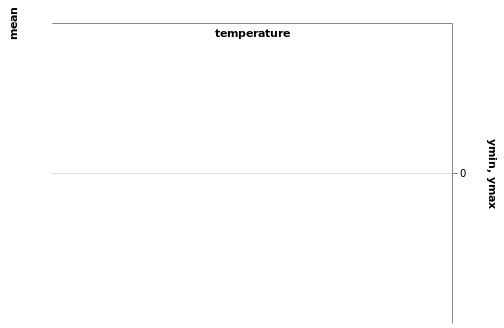

In [10]:
chart = alt.Chart(gradient1).mark_point().transform_calculate(
    ymin="datum.mean-datum.error/2",
    ymax="datum.mean+datum.error/2"
).encode(
    alt.X('temperature:Q', scale=alt.Scale(zero=False))
)

disp_chart = (
    chart.encode(alt.Y('mean', axis=alt.Axis(format='e'))) + 
    chart.mark_rule().encode(y='ymin:Q', y2='ymax:Q')
)
disp_chart